In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
from curlyBrace import curlyBrace
import random

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

In [2]:
qid = 7638

tags = Tag.objects.filter(query_id=qid, seen_docs__gt=0)

import scipy.stats as st

def ci_ac(X, n, a):
    def get_k(a):
        a = (1-(1-a)/2)
        return st.norm.ppf(a)

    k = get_k(a)

    X_tilde = X + k**2/2
    n_tilde = n + k**2
    p_tilde = X_tilde / n_tilde
    q_tilde = 1-p_tilde

    ci = k* np.sqrt(p_tilde*q_tilde/n_tilde) 

    return p_tilde, ci

def plot_alphas(X,n, r_docs, unseen, ax):

    alphas = [x*0.01 for x in range(100)]
    ys = [sum(ci_ac(X,n,x)) for x in alphas]

    unseen = unseen + 100 - n
    rs = [y*unseen for y in ys]
    recalls = [r_docs/(r_docs+r) for r in rs]

    ax.plot(alphas,recalls,color="#bdbdbd"
           )

    thresh = [[0.5,False],[0.6666,False],[0.9,False],[0.95,False]]
    for a,x in zip(alphas,recalls):
        for i, t in enumerate(thresh):
            if a>t[0] and t[1]==False:
                text = f"<{1-t[0]:.0%} that R < {x:.2%}"
                ax.annotate(
                    text,(a,x), xytext=(a-0.1,x-0.1-0.02*i), ha="right",va="top",
                    arrowprops=dict(facecolor='black', 
                        shrink=0.08,width=0.5,headwidth=6,headlength=8
                   )
                )
                t[1] = True

                
    ax.set_title(f"X={X}, n={n}")
    ax.set_xlabel("Confidence level")
    ax.set_ylabel("Minimum recall (R)")

tags


<QuerySet [<Tag: predicted relevant sample 2019-12-16 16:33>, <Tag: predicted relevant sample 2019-12-04 10:56>, <Tag: db1_maybe>, <Tag: predicted relevant sample 2019-11-25 19:10>, <Tag: predicted relevant sample 2019-11-13 14:02>, <Tag: predicted relevant sample (comparison) 2019-11-08 10:52>, <Tag: predicted relevant sample 2019-10-23 17:17>, <Tag: unrated by lea>, <Tag: predicted relevant sample (comparison) 2019-10-25 17:07>, <Tag: MaybesDB2>, <Tag: Probably Africa>, <Tag: unrated_with_abstract>, <Tag: unassigned_with_abstract>, <Tag: all>]>

8592
all
100
0.22
unrated_with_abstract
50
0.2
unassigned_with_abstract
718
0.135097493036212
Probably Africa
1617
0.205318491032777
predicted relevant sample 2019-10-23 17:17
992
0.671370967741935
unrated by lea
568
0.205985915492958
MaybesDB2
60
0.766666666666667
predicted relevant sample (comparison) 2019-10-25 17:07
100
0.6
predicted relevant sample (comparison) 2019-11-08 10:52
1000
0.567
predicted relevant sample 2019-11-13 14:02
1000
0.519
predicted relevant sample 2019-11-25 19:10
1000
0.265
predicted relevant sample 2019-12-04 10:56
999
0.38038038038038
db1_maybe
3
0.0
predicted relevant sample 2019-12-16 16:33
448
0.229910714285714


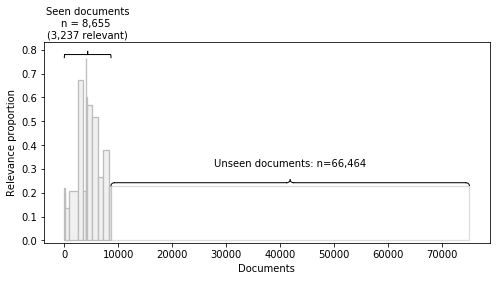

In [8]:
r_in_tags = DocOwnership.objects.filter(relevant__gt=0,tag__in=tags).values_list('doc__pk',flat=True)

print(len(set(r_in_tags)))

other_docs = Doc.objects.filter(
    query=qid
).exclude(
    pk__in=set(r_in_tags)
)

unseen = other_docs.count()

r_in_tags = DocOwnership.objects.filter(relevant=1, tag__in=tags)
r_docs = Doc.objects.filter(pk__in=r_in_tags).count()

alpha = 0.95

ab_bottom=0.0
lw = 1.3

n = 0

if "random" in tags.order_by('id').last().title:
    fig, axs = plt.subplots(2, figsize=(7,7))
    ax = axs[0]
else:
    fig, ax = plt.subplots(figsize=(7,4))
     

max_r = 0

for t in tags.order_by('id'):
    print(t)
    print(t.seen_docs)
    print(t.relevance)
    max_r = max(max_r,t.relevance)
    ax.bar(
        n, t.relevance+ab_bottom, bottom=-ab_bottom, width=t.seen_docs, 
        align="edge",color="#f0f0f0", edgecolor="#bdbdbd", linewidth=lw
        
    )
    n+=t.seen_docs
    


str_text = f"Seen documents\nn = {n:,} \n({r_docs:,} relevant)"

curlyBrace(
    fig, ax, (0,max_r), (n,max_r), 0.01, 
    bool_auto=True, str_text=str_text, color="black", lw=1, int_line_num=1
)

w = len(set(other_docs.values_list('pk',flat=True)))

ax.bar(
    n, t.relevance+ab_bottom, bottom=-ab_bottom, width=w, align="edge",
    color="white", edgecolor="#bdbdbd",alpha=0.5, linewidth=lw
)
ax.set_xlabel("Documents")
ax.set_ylabel("Relevance proportion")

ax.set_ylim(ymin=-0.01,)

if "random" in t.title:
    ax.annotate(
        f"Random sample:\nn={t.seen_docs},\nrelevance={t.relevance:.2%}",
        (n,t.relevance), xytext=(n+w*0.1,0.2),
        arrowprops=dict(facecolor='black', shrink=0.08,width=0.5,headwidth=6,headlength=8)
    )
    r_hat = ci_ac(round(t.relevance*t.seen_docs),t.seen_docs,0.95)

    print(r_hat)

    ax.errorbar(
        n+w*0.5, r_hat[0], yerr=r_hat[1],capsize=10,
        color="#bdbdbd"
    )

    if r_hat[0]-r_hat[1] < 0:
        lb = 0
    else:
        lb = r_hat[0]-r_hat[1]

    ax.annotate(
        f"Unseen documents:\nn={w:,},\nrelevance (95CI) =\n[{lb:.2%},{sum(r_hat):.2%}]\
        \n[{round(lb*unseen):,.0f},{round(sum(r_hat)*unseen):,.0f}]",
        (n+w*0.5,sum(r_hat)),
        xytext=(n+w*0.6, 0.2),
        arrowprops=dict(facecolor='black', 
                        shrink=0.08,width=0.5,headwidth=6,headlength=8
                       )
    )
    plot_alphas(t.rel_docs, t.seen_docs, r_docs, unseen, ax = axs[1])

    axs[1].set_title("b) Probable Recall")
    axs[0].set_title("a) Screening Progress")
else:
    curlyBrace(
        fig, ax, (n,t.relevance+ab_bottom), (n+w,t.relevance+ab_bottom), 0.01, 
        bool_auto=True, str_text=f"Unseen documents: n={w:,}", color="black", lw=1, int_line_num=1
    )

fig.tight_layout()
    
plt.show()

In [4]:
r_in_tags = DocOwnership.objects.filter(relevant=1, tag__in=tags).values_list('doc__pk',flat=True)
r_docs = Doc.objects.filter(pk__in=r_in_tags)
print(r_docs.count())
print(r_docs.filter(category__name__in=["Maybe","Yes"]).count())

3141
2110


In [5]:
1698/2527

0.6719430154333201

In [6]:
4000*0.67


2680.0

There is a < 50% chance that r > 1.00%
There is a < 33% chance that r > 1.32%
There is a < 10% chance that r > 2.50%
There is a < 5% chance that r > 3.06%


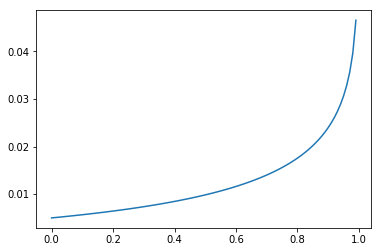

TypeError: unsupported operand type(s) for +: 'Doc' and 'float'

In [23]:

alphas = [x*0.01 for x in range(100)]
ys = [sum(ci_ac(1,200,x)) for x in alphas]

thresh = [[0.5,False],[0.6666,False],[0.9,False],[0.95,False]]
for a,x in zip(alphas,ys):
    for t in thresh:

        if a>t[0] and t[1]==False:
            print(f"There is a < {1-t[0]:.0%} chance that r > {x:.2%}")
            t[1] = True
    
plt.plot(alphas,ys)

plt.show()

unseen = other_docs.count()
all_relevant = DocOwnership.objects.filter(relevant=1,)
rs = [y*unseen for y in ys]
recalls = [r_docs/(r_docs+r) for r in rs]

plt.plot(alphas,recalls)

thresh = [[0.5,False],[0.6666,False],[0.9,False],[0.95,False]]
for a,x in zip(alphas,recalls):
    for t in thresh:
        if a>t[0] and t[1]==False:
            print(f"There is a < {1-t[0]:.0%} chance that recall < {x:.2%}")
            t[1] = True


TypeError: unsupported operand type(s) for +: 'Doc' and 'float'

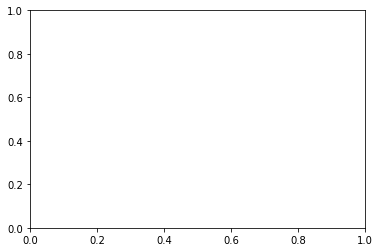

In [24]:
   
fig, ax = plt.subplots()
plot_alphas(0,100, r_docs, unseen, ax = ax)
plt.show()

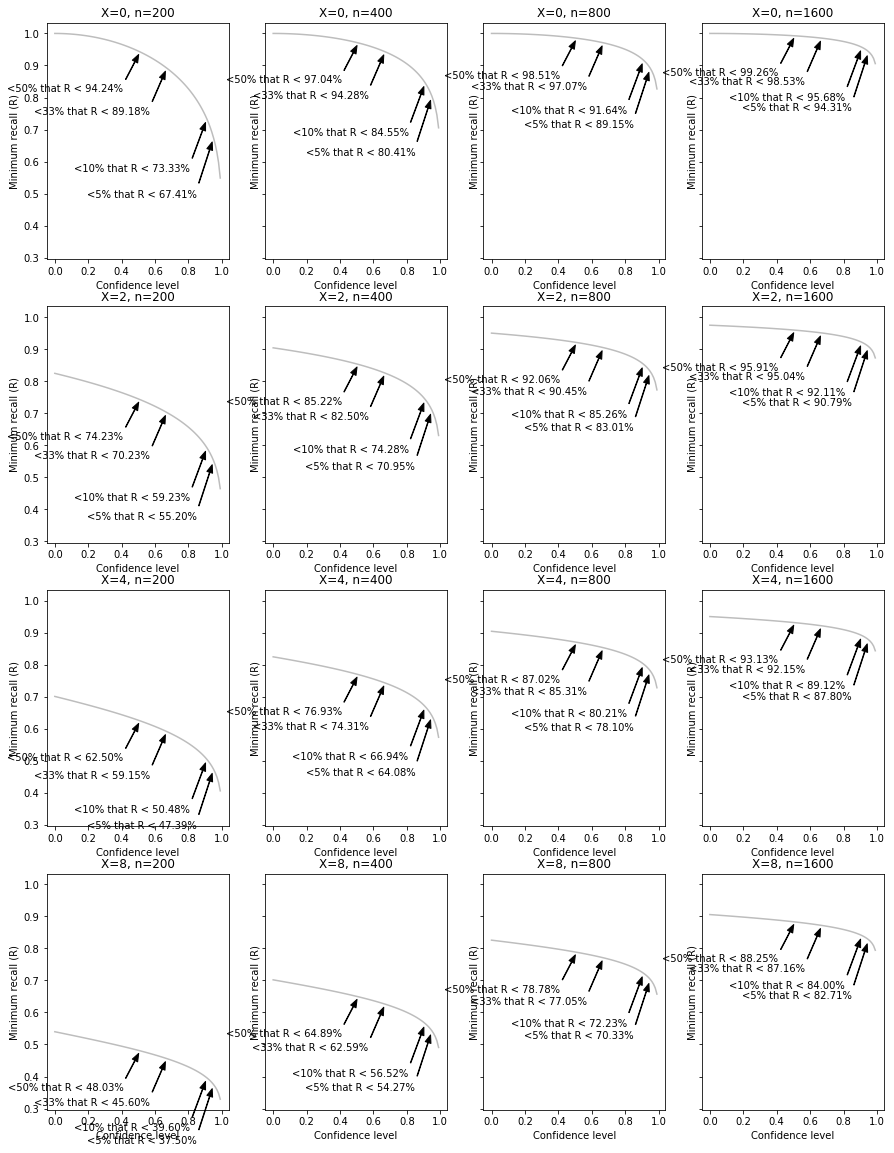

In [10]:
fig, axs = plt.subplots(4,4,sharey=True, figsize=(15,20))
for j,X in enumerate([0,2,4,8]):
    for i,n in enumerate([200,400,800,1600]):
        ax = axs[j,i]
        if n==100 and X>0:
            continue
        plot_alphas(X,n, r_docs, unseen, ax = ax)

In [7]:
newtag = False
if newtag:
    s = random.sample(set(other_docs.values_list('pk',flat=True)),100)
    import datetime
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
    q = Query.objects.get(pk=6973)
    t1 = Tag(
        title="random sample {}".format(now),
        query=q
    )
    t1.save()

    for did in s:
        d = Doc.objects.get(pk=did)
        d.tag.add(t1)


    t1.update_tag()